In [1]:
import tensorflow as tf
import numpy as np
import os
import json
import nrrd
import matplotlib.pyplot as plt
import random
import utils
import time
import model_utils


In [2]:
with open(r'C:\Users\rajkif\Documents\maskrcnn/toy_dataset/dataInfo.json') as j:
     DATAJSON = json.loads(j.read())
        
IMAGEFOLDER=r'C:\Users\rajkif\Documents\maskrcnn/toy_dataset/images'
MASKFOLDER=r'C:\Users\rajkif\Documents\maskrcnn/toy_dataset/masks'
NUMOFTRAINDATAS=7500
NUMOFTESTDATAS=1500
BATCHLEN=3
BATCHPEREPOCH=NUMOFTRAINDATAS/BATCHLEN
PROPOSALCOUNT=20
ROISIZE=[5,5]
MASKROISIZE=[14,14]
CLASSDICT={0:'heart',1:'star'}

#finetune parameters
FINETUNEEPOCHS=3
FINETUNETRAINDATAS=1000

### Kimentett modellek betöltése


In [3]:

#models
cnnmodel=tf.keras.models.load_model('saved_models/fullbackbone.h5')
fmmodel=tf.keras.models.load_model('saved_models/featuremapmodel.h5')
rpnmodel=tf.keras.models.load_model('saved_models/rpn7500.h5')
classheadmodel=tf.keras.models.load_model('saved_models/classhead7500.h5')
maskheadmodel=tf.keras.models.load_model('saved_models/maskhead7500.h5')

featuremap=[layer for layer in cnnmodel.layers if layer.name=='featuremap']
featuremap=featuremap[0].output
FEATURESHAPE=featuremap.shape
FEATURESIZE=[featuremap.shape[1],featuremap.shape[2]]
FEATUREFILTER=featuremap.shape[-1]
ALLANCHORS=utils.generate_anchors(featuremap)


Num of generated anchors:	 5120


### Új modellek lerakása

In [4]:
# #models

# cnnmodel,fmmodel=model_utils.backboneNN()

# featuremap=[layer for layer in cnnmodel.layers if layer.name=='featuremap']
# featuremap=featuremap[0].output
# FEATURESHAPE=featuremap.shape
# FEATURESIZE=[featuremap.shape[1],featuremap.shape[2]]
# FEATUREFILTER=featuremap.shape[-1]
# ALLANCHORS=utils.generate_anchors(featuremap)

# rpnmodel=model_utils.rpnN(featuremap)
# classheadmodel=model_utils.classheadNN(FEATUREFILTER,PROPOSALCOUNT,ROISIZE)
# maskheadmodel=model_utils.maskheadNN(FEATUREFILTER,PROPOSALCOUNT,MASKROISIZE)

In [5]:
image_batch,masks_batch,bbox_batch,label_batch=utils.read_batch(IMAGEFOLDER,MASKFOLDER,DATAJSON,batchlen=BATCHLEN,start=14)
#béna pl. 8456,8889
#menő pl 8965,8389



In [6]:
predicted_mask_batch,predicted_boxes_batch,predicted_scores_batch,predicted_label_batch=model_utils.predict_all(image_batch,ALLANCHORS,BATCHLEN,fmmodel,rpnmodel,classheadmodel,maskheadmodel)


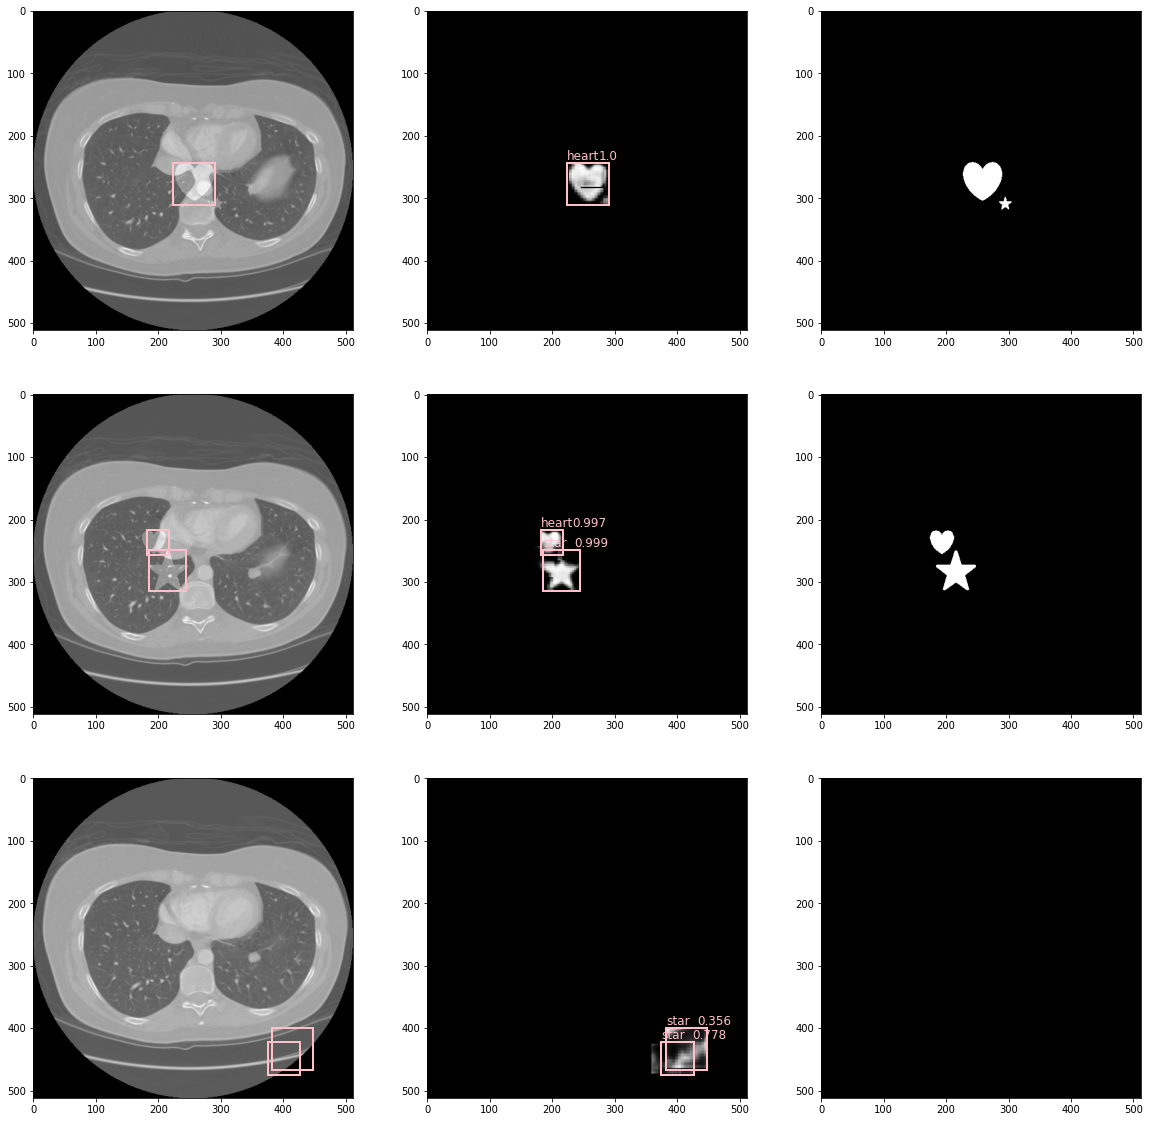

In [7]:
plt.rcParams["figure.figsize"] = (20,20)
utils.visualize_results(image_batch,predicted_mask_batch,predicted_label_batch,predicted_boxes_batch,predicted_scores_batch,CLASSDICT,BATCHLEN,masks_batch)

## Bármely háló továbbtanítása

#### Backbone

In [8]:
batchgen_cnn=model_utils.batchgenerator_cnn(datafolder=IMAGEFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,numofdatas=FINETUNETRAINDATAS)
cnnmodel.fit(batchgen_cnn,epochs=1,steps_per_epoch=BATCHPEREPOCH)

2500/2500 [==============================] - 119s 47ms/step - loss: 0.0223 - binary_accuracy: 0.99353s - loss


#### RPN

In [9]:
model_utils.train_rpn(rpnmodell=rpnmodel,fmmodel=fmmodel,allanchors=ALLANCHORS,proposalcount=PROPOSALCOUNT,\
                      datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=FINETUNEEPOCHS,numofdatas=FINETUNETRAINDATAS) 


c:\programdata\miniconda3\envs\tf_24\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\rajkif\Documents\maskrcnn\GIT\mesterseges-intelligencia\utils.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_of_bboxes=np.array(batch_of_bboxes)


31 sec. 	 0 .epoch:	 loss(sum,c,bb):	 2.0443387 0.06839339 1.9759454
30 sec. 	 1 .epoch:	 loss(sum,c,bb):	 1.4771276 0.05102179 1.4261057
31 sec. 	 2 .epoch:	 loss(sum,c,bb):	 1.402138 0.0460688 1.3560691


#### Classh-head, Box refinement

In [10]:
model_utils.train_classhead(classheadmodel=classheadmodel,rpnmodel=rpnmodel,fmmodel=fmmodel,allanchors=ALLANCHORS,roisize=ROISIZE,\
                            numofdatas=FINETUNETRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=FINETUNEEPOCHS) 


C:\Users\rajkif\Documents\maskrcnn\GIT\mesterseges-intelligencia\utils.py:200: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_of_bboxes=np.array(batch_of_bboxes)


27 sec. 	 0 .epoch: 	 loss(c,bb):	 0.33278665 57.20436
27 sec. 	 1 .epoch: 	 loss(c,bb):	 0.2921924 52.524815
26 sec. 	 2 .epoch: 	 loss(c,bb):	 0.2623819 50.723545


#### Mask-head

In [11]:
model_utils.train_maskhead(maskheadmodel=maskheadmodel,rpnmodel=rpnmodel,fmmodel=fmmodel,allanchors=ALLANCHORS,maskroisize=MASKROISIZE,\
                           numofdatas=FINETUNETRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=FINETUNEEPOCHS) 

40 sec. 	 0 .epoch: 	 loss:	 nan
40 sec. 	 1 .epoch: 	 loss:	 0.2317848
39 sec. 	 2 .epoch: 	 loss:	 0.22459972


#### complex network 

In [12]:
model_utils.train_complex(fmmodel=fmmodel,rpnmodel=rpnmodel,classheadmodel=classheadmodel,maskheadmodel=maskheadmodel,\
                          allanchors=ALLANCHORS,proposalcount=PROPOSALCOUNT, roisize=ROISIZE,maskroisize=MASKROISIZE,\
                          numofdatas=FINETUNETRAINDATAS,datafolder=IMAGEFOLDER,maskfolder=MASKFOLDER,jsonfile=DATAJSON,batchlen=BATCHLEN,epochs=FINETUNEEPOCHS) 

68 sec. 	 0 .epoch: 	 rpn loss: 1.359895 	ch loss: 42.42974 	mask loss: 0.17903309
68 sec. 	 1 .epoch: 	 rpn loss: 0.91782135 	ch loss: 36.849277 	mask loss: 0.16149858
69 sec. 	 2 .epoch: 	 rpn loss: 0.62357825 	ch loss: 30.032494 	mask loss: 0.1478703


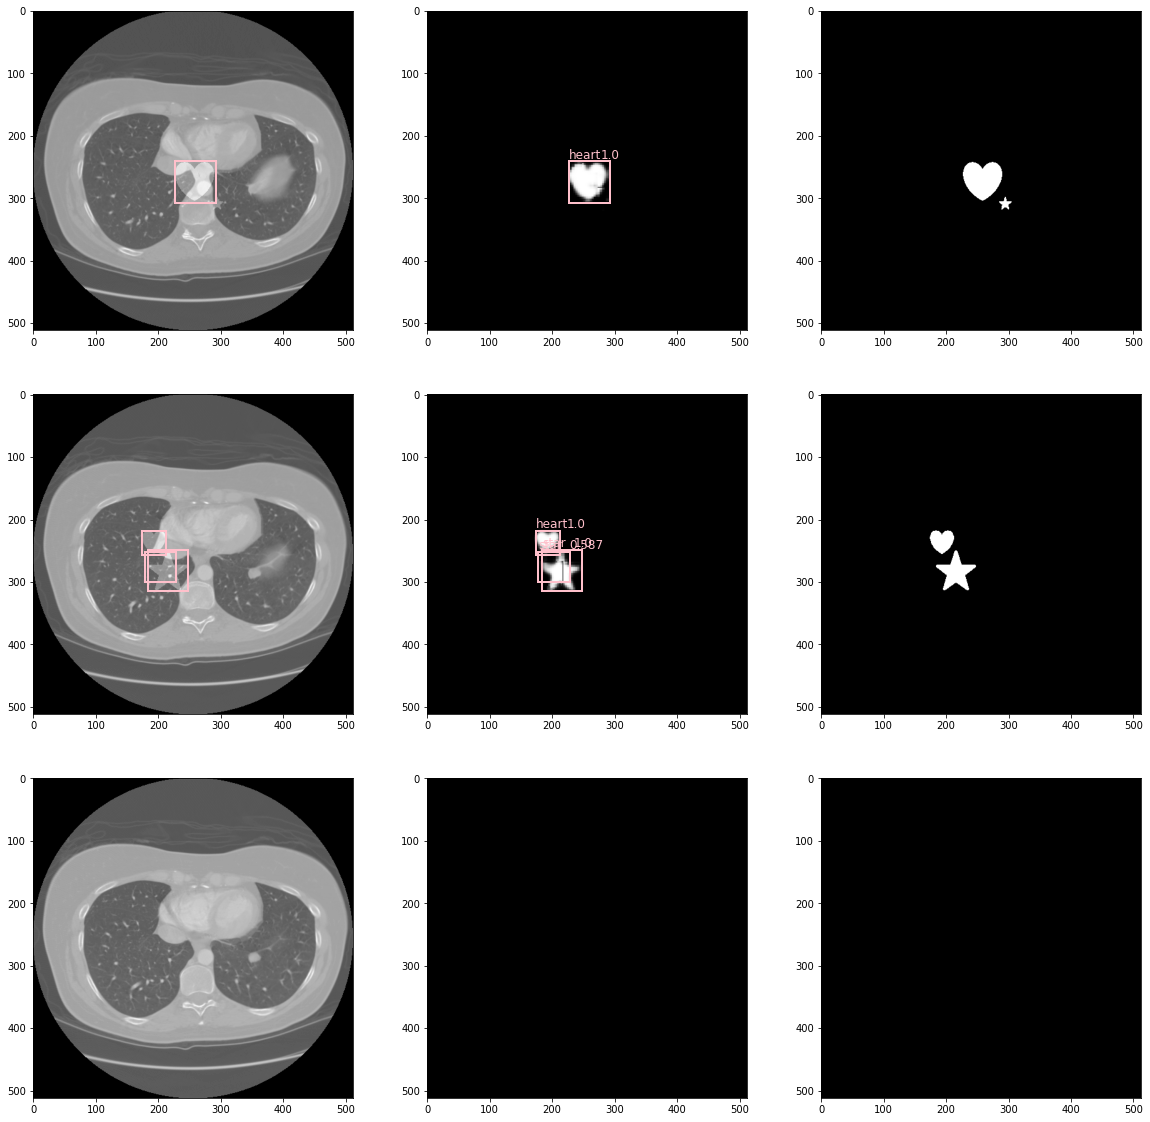

In [13]:
predicted_mask_batch,predicted_boxes_batch,predicted_scores_batch,predicted_label_batch=model_utils.predict_all(image_batch,ALLANCHORS,BATCHLEN,fmmodel,rpnmodel,classheadmodel,maskheadmodel)
plt.rcParams["figure.figsize"] = (20,20)
utils.visualize_results(image_batch,predicted_mask_batch,predicted_label_batch,predicted_boxes_batch,predicted_scores_batch,CLASSDICT,BATCHLEN,masks_batch)

### Saving models

In [ ]:
#suffix='_'+str(FINETUNETRAINDATAS)+'datas'+str(FINETUNEEPOCHS)+'epochs'

# cnnmodel.save('saved_models/fullbackbone'+suffix+'.h5')
# fmmodel.save('saved_models/fmmodel'+suffix+'.h5')
# rpnmodel.save('saved_models/rpnmodel'+suffix+'.h5')
# classheadmodel.save('saved_models/classheadmodel'+suffix+'.h5')
# maskheadmodel.save('saved_models/maskheadmodel'+suffix+'.h5')

